In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import f1_score

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle

### 프로젝트 셋팅

In [3]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_pitcher_data_3th.dat'

# 교차검증 횟수
cv_count = 10

# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)

# 평가 결과를 담을 리스트
# 필요하다면 다른 것도 만들어주세요
f1_macro_list = []
f1_micro_list = [] 

# 학습 모델 이름
model_name_list = []

### 데이터 준비

In [5]:
df_pit = pd.read_csv('merged_pitchers_fixed.csv')
df_sal = pd.read_csv('선수 연봉 구간 데이터(4구간).csv')

In [6]:
# 1. 칼럼명 변경
df_pit = df_pit.rename(columns={'Name_x': '선수'})

# 2. 칼럼 맞추기 
df_pit['pid'] = df_pit['pid'].astype(int)

In [7]:
# 데이터 병합 
df_merged = pd.merge(df_pit, df_sal[['pid', '연봉등급']], on='pid')
df_merged

,pid,선수,포지션,팀,ERA,FIP,WHIP,SO_x,BB_x,HR_x,...,S,HD,pit_G,CG,SHO,GR,GF,연봉(만원),WAR,연봉등급
0,10058,양현종,투수,KIA 타이거즈,3.840,4.165,1.295,131.0,44.5,17.0,...,0.0,0.0,58.0,3.0,0.0,0.0,3.0,100000.0,4.265,A
1,10075,진해수,투수,LG 트윈스,4.930,5.680,1.785,17.0,10.0,3.5,...,0.0,7.0,73.0,0.0,0.0,73.0,6.0,40000.0,0.005,C
2,10124,고효준,투수,SSG 랜더스,6.340,5.140,1.760,46.5,31.0,3.5,...,0.0,18.0,99.0,0.0,0.0,99.0,9.0,23800.0,0.365,C
3,10126,김광현,투수,SSG 랜더스,4.230,4.645,1.415,136.5,71.5,17.5,...,0.0,0.0,61.0,0.0,0.0,0.0,0.0,200000.0,4.195,A
4,10131,박종훈,투수,SSG 랜더스,6.565,6.535,1.685,45.0,40.5,7.5,...,0.0,0.0,28.0,0.0,0.0,3.0,1.0,160000.0,0.340,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,16133,박범준,투수,키움 히어로즈,13.500,5.590,2.060,8.0,4.0,1.0,...,0.0,0.0,5.0,0.0,0.0,5.0,3.0,3000.0,-0.110,D
255,16138,헤이수스,투수,키움 히어로즈,3.680,4.110,1.250,178.0,44.0,22.0,...,0.0,0.0,30.0,0.0,0.0,0.0,0.0,60000.0,4.650,A
256,16146,앤더슨,투수,SSG 랜더스,3.890,3.550,1.310,158.0,53.0,11.0,...,0.0,0.0,24.0,0.0,0.0,1.0,0.0,57000.0,4.130,A
257,16153,와이스,투수,한화 이글스,3.730,3.650,1.160,98.0,29.0,8.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,4800.0,3.160,A


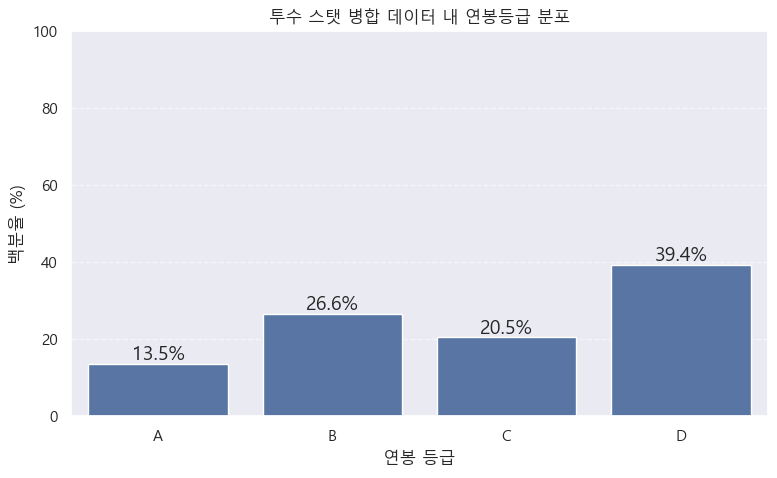

In [8]:
# 연봉등급 비율 계산
grade_pct = df_merged['연봉등급'].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x=grade_pct.index, y=grade_pct.values)
plt.ylabel('백분율 (%)')
plt.xlabel('연봉 등급')
plt.title('투수 스탯 병합 데이터 내 연봉등급 분포')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 막대 위에 숫자 표시
for i, v in enumerate(grade_pct.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

In [25]:
# 연봉 등급 인코딩 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_merged['연봉등급'])

In [27]:
# 표준화를 위해 결과데이터를 제외한다.
X = df_merged.drop(['pid', '선수', '포지션', '팀', '연봉(만원)', '연봉등급'], axis=1)

# 표준화
scaler1 = StandardScaler()
scaler1.fit(X)

StandardScaler()

In [29]:
# y 저장
y = df_merged['연봉등급']

# 인코딩 전에 y 원본 백업
y_raw = df_merged['연봉등급'].copy()

In [31]:
# train test 분리 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [33]:
# 표준화
scaler1.fit(X_train)

StandardScaler()

In [35]:
train_X = scaler1.transform(X_train)
test_X = scaler1.transform(X_test)

In [37]:
train_y = y_train
test_y = y_test

### 기본 모델 사용하기

In [ ]:
# GradientBoost
gb_basic_model = GradientBoostingClassifier()

# 교차 검증을 수행한다
f1_macro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(gb_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()


# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoost Basic")

In [ ]:
# LGBM
lgbm_basic_model = LGBMClassifier(verbose=-1)

# 교차 검증을 수행한다
f1_macro = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(lgbm_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Basic")

In [ ]:
# XGBoost
xgboost_basic_model = XGBClassifier(verbose=-1, silent=True)

# 교차 검증을 수행한다
f1_macro = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Basic")

In [ ]:
# HardVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

hard_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_basic_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 교차 검증을 수행한다
f1_macro = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Basic")

In [ ]:
# SoftVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

soft_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_basic_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(soft_voting_basic_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Basic")

In [ ]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

# 출력
display(result_df)

### 하이퍼 파라미터 튜닝 

In [ ]:
# GradientBoosting
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# 기본 모델 정의
temp_model = GradientBoostingClassifier()

# GridSearchCV: f1_macro 기준으로 튜닝
gb_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
gb_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_gb_model = gb_grid_clf.best_estimator_

# f1_macro, f1_micro 각각 평가
f1_macro = cross_val_score(best_gb_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_gb_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoosting Tuning")

In [ ]:
# LGBM
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# LGBM 모델 정의
temp_model = LGBMClassifier(verbose=-1, random_state=42)

# f1_macro 기준으로 하이퍼파라미터 튜닝
lgbm_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
lgbm_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_lgbm_model = lgbm_grid_clf.best_estimator_

# f1_macro, f1_micro 평가
f1_macro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_lgbm_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Tuning")

In [ ]:
# XGBoost
params = {
    'booster': ['gbtree'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# 모델 정의
temp_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0, random_state=42)

# f1_macro 기준으로 튜닝
xgboost_grid_clf = GridSearchCV(temp_model, param_grid=params, scoring='f1_macro', cv=kfold)
xgboost_grid_clf.fit(train_X, train_y)

# 최적 모델 추출
best_xgb_model = xgboost_grid_clf.best_estimator_

# 성능 평가
f1_macro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(best_xgb_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Tuning")

In [ ]:
# HardVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

# 하이퍼 파라미터 셋팅
temp_model7.set_params(**gb_grid_clf.best_params_)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

hard_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

hard_voting_tuning_model = VotingClassifier(estimators=hard_voting_model_list, voting='hard')

# 성능 평가 (교차검증)
f1_macro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("HardVoting Tuning")

In [ ]:
# SoftVoting 구성
temp_model7 = GradientBoostingClassifier()
temp_model8 = LGBMClassifier(verbose=-1)
temp_model9 = XGBClassifier(verbose=-1, silent=True)

# 하이퍼 파라미터 셋팅
temp_model7.set_params(**gb_grid_clf.best_params_)
temp_model8.set_params(**lgbm_grid_clf.best_params_)
temp_model9.set_params(**xgboost_grid_clf.best_params_)

soft_voting_model_list = [
    ('model7', temp_model7),
    ('model8', temp_model8),
    ('model9', temp_model9),
]

soft_voting_tuning_model = VotingClassifier(estimators=soft_voting_model_list, voting='soft')

# 교차 검증을 수행한다
f1_macro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_macro', cv=kfold).mean()
f1_micro = cross_val_score(hard_voting_tuning_model, train_X, train_y, scoring='f1_micro', cv=kfold).mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("SoftVoting Tuning")

In [ ]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df.sort_values(by='F1 Macro', ascending=False, inplace=True)

# 출력
display(result_df)

### 혼동 행렬 그리기 

In [ ]:
# LGBM
best_lgbm_model.fit(train_X, train_y)
y_pred = best_lgbm_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("LGBM Confusion Matrix")
plt.show()

In [ ]:
# XGBoost
best_xgb_model.fit(train_X, train_y)
y_pred = best_xgb_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()

In [ ]:
# Hard Voting
hard_voting_tuning_model.fit(train_X, train_y)
y_pred = hard_voting_tuning_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("Hard Voting Confusion Matrix")
plt.show()

In [ ]:
# Soft Voting
soft_voting_tuning_model.fit(train_X, train_y)
y_pred = soft_voting_tuning_model.predict(train_X)

cm = confusion_matrix(train_y, y_pred, labels=[0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D', 'E'])
disp.plot(cmap='Blues')
plt.title("Soft Voting Confusion Matrix")
plt.show()

In [ ]:
10/0

In [ ]:
# 최종 모델을 생성하고 전체 데이터를 학습 시킨다.
best_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
best_model.set_params(**xgboost_grid_clf.best_params_)
best_model.fit(train_X, train_y)
best_model

In [ ]:
# 학습 모델 등을 저장한다.
save_objects = {
    'model': best_model,
    'encoder': encoder,  
    'scaler': scaler1     
}

with open(best_model_path, 'wb') as fp:
    pickle.dump(save_objects, fp)

In [ ]:
# 저장 확인
# 불러오기
with open(best_model_path, 'rb') as fp:
    loaded = pickle.load(fp)

# 추출
test_model = loaded['model']
test_encoder = loaded.get('encoder')  # 없는 경우 None
test_scaler = loaded.get('scaler')

In [ ]:
r1 = test_model.predict(train_X)
r2 = f1_score(train_y, r1, average='macro')  # 또는 'micro'
print("F1 Macro:", r2)